In [1]:
import numpy as np
import matplotlib.pyplot as plt


configuramos los parametros de la simulación

In [2]:
N = 1000
fs = 1000.0  # frecuencia de muestreo (Hz)
ts = 1 / fs  # tiempo de muestreo
df = fs / N  # resolución espectral
A=2
R = 200 # realizaciones, cantidad de experimentos


In [3]:
from scipy.signal import get_window

def señal_experimental(A, omega_zero, N, fs, snr, R, window=None):
    ts = 1 / fs
    tt = np.linspace(0, (N - 1) * ts, N)
    sig_pow = (A**2) / 2

    noise_pow = sig_pow / 10**(snr / 10)
    n = np.random.normal(0, noise_pow, N)
    fr = np.random.uniform(low=-2, high=2, size=R)

    omega_one = (omega_zero + fr) * df

    x = np.array([A * np.sin(2 * np.pi * o1 * tt) + n for o1 in omega_one])
    x = x.transpose()

    if window is not None:
        try:
            win = get_window(window, N)
            x = x * win[:, np.newaxis]
        except ValueError:
            raise ValueError(f"Unknown or unsupported window type: {window}")

    return x, noise_pow

In [4]:
s, pn = señal_experimental(A=A, omega_zero=N/4, N=N, fs=fs, snr=10, R=R, window=None)
s_bh, pn_bh = señal_experimental(A=A, omega_zero=N/4, N=N, fs=fs, snr=10, R=R, window='blackmanharris')
s_ft, pn_ft = señal_experimental(A=A, omega_zero=N/4, N=N, fs=fs, snr=10, R=R, window='flattop')



En el siguiente grafico podemos observar como la energía de nuestra señal se desparrama en el espectro en vez de estar concentrada como una delta, producto de que la frecuencia de nuestra señal (debido a que esta es una variable estocastica) no es multiplo entero de la densidad espectral, por lo cual la energía de la delta se reparte en los bins adyacentes.

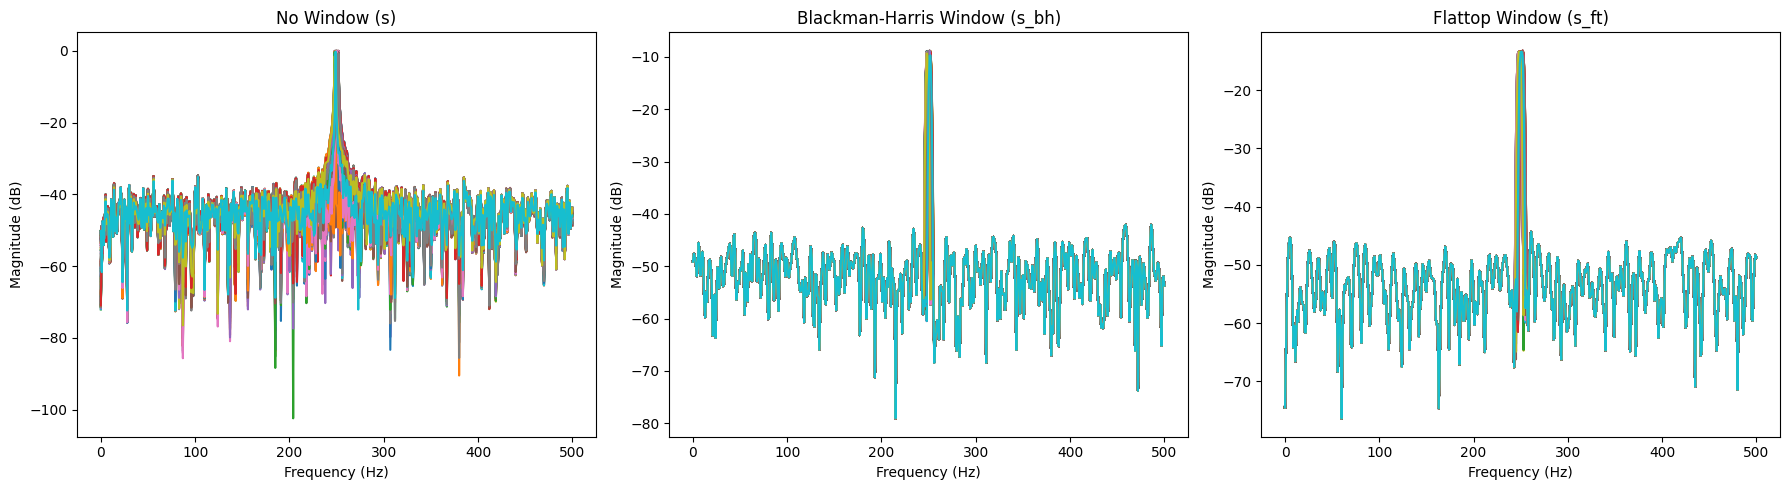

In [5]:

# Frequency array
ff = np.linspace(0, (N - 1) * df, N)

# Calculate the FFT of each signal
ft_s = (1 / N) * np.fft.fft(s, axis=0)
ft_s_bh = (1 / N) * np.fft.fft(s_bh, axis=0)
ft_s_ft = (1 / N) * np.fft.fft(s_ft, axis=0)

# Calculate magnitude in dB for each signal
magnitude_s = 20 * np.log10(np.abs(ft_s))
magnitude_s_bh = 20 * np.log10(np.abs(ft_s_bh))
magnitude_s_ft = 20 * np.log10(np.abs(ft_s_ft))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  

# Plot for 's' (no windowing)
axs[0].plot(
    ff[ff <= fs / 2],
    magnitude_s[ff <= fs / 2],
)
axs[0].set_title('No Window (s)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude (dB)')

# Plot for 's_bh' (Blackman-Harris window)
axs[1].plot(
    ff[ff <= fs / 2],
    magnitude_s_bh[ff <= fs / 2],
)
axs[1].set_title('Blackman-Harris Window (s_bh)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude (dB)')

# Plot for 's_ft' (Flattop window)
axs[2].plot(
    ff[ff <= fs / 2],
    magnitude_s_ft[ff <= fs / 2],
)
axs[2].set_title('Flattop Window (s_ft)')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('Magnitude (dB)')

plt.tight_layout()
plt.show()

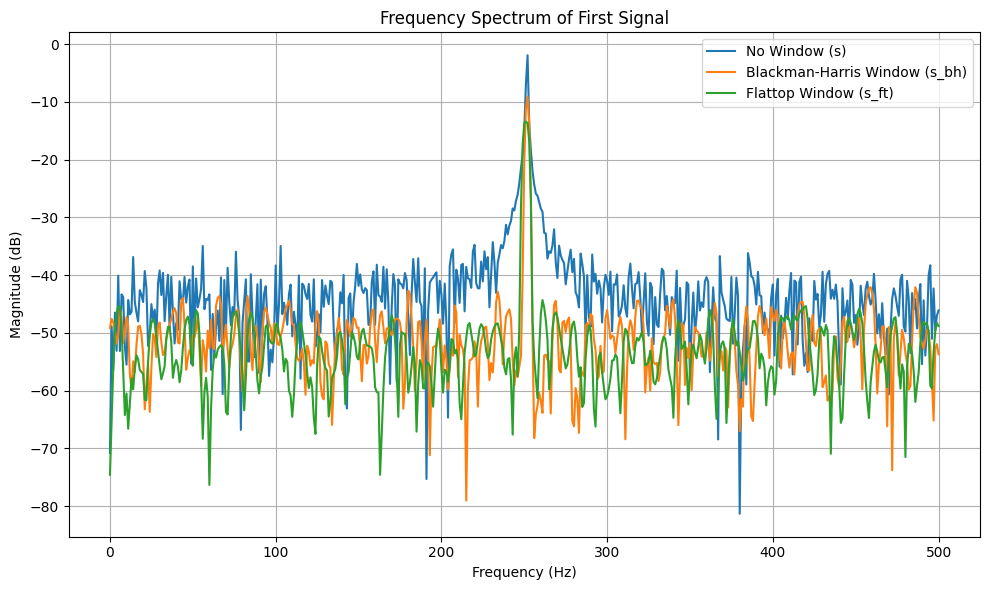

In [6]:

ff = np.linspace(0, (N - 1) * df, N)

ft_s = (1 / N) * np.fft.fft(s[:, 0], axis=0)
ft_s_bh = (1 / N) * np.fft.fft(s_bh[:, 0], axis=0)
ft_s_ft = (1 / N) * np.fft.fft(s_ft[:, 0], axis=0)

# Calculate magnitude in dB for each signal
magnitude_s = 20 * np.log10(np.abs(ft_s))
magnitude_s_bh = 20 * np.log10(np.abs(ft_s_bh))
magnitude_s_ft = 20 * np.log10(np.abs(ft_s_ft))

plt.figure(figsize=(10, 6))

plt.plot(
    ff[ff <= fs / 2],
    magnitude_s[ff <= fs / 2],
    label='No Window (s)'
)

plt.plot(
    ff[ff <= fs / 2],
    magnitude_s_bh[ff <= fs / 2],
    label='Blackman-Harris Window (s_bh)'
)

plt.plot(
    ff[ff <= fs / 2],
    magnitude_s_ft[ff <= fs / 2],
    label='Flattop Window (s_ft)'
)

# Set plot details
plt.title('Frequency Spectrum of First Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
def a_10_hat_estimator_with_error(signal, A, N):
    ft = (1 / N) * np.fft.fft(signal, axis=0)
    a10_hat = abs(ft[int(N/4), :])
    a10_hat_mean =  a10_hat.mean()
    a10_hat_error = (abs((A/2) - a10_hat_mean)/(A/2)) * 100
    a10_hat_bias = np.mean(a10_hat - A/2)
    return a10_hat, a10_hat_mean, a10_hat_bias

In [8]:
a10_hat, a10_hat_mean, a10_hat_error = a_10_hat_estimator_with_error(s, A, N)
a10_hat_bh, a10_hat_mean_bh, a10_hat_error_bh = a_10_hat_estimator_with_error(s_bh, A, N)
a10_hat_ft, a10_hat_mean_ft, a10_hat_error_ft = a_10_hat_estimator_with_error(s_ft, A, N)

# Results for original signal (no window)
print("Original Signal (No Window):")
print(f"a10_hat_mean: {a10_hat_mean}")
print(f"a10_hat_error: {a10_hat_error}\n")

# Results for Blackman-Harris windowed signal
print("Blackman-Harris Windowed Signal:")
print(f"a10_hat_mean_bh: {a10_hat_mean_bh}")
print(f"a10_hat_error_bh: {a10_hat_error_bh}\n")

# Results for Flattop windowed signal
print("Flattop Windowed Signal:")
print(f"a10_hat_mean_ft: {a10_hat_mean_ft}")
print(f"a10_hat_error_ft: {a10_hat_error_ft}\n")

Original Signal (No Window):
a10_hat_mean: 0.37621316623419887
a10_hat_error: -0.6237868337658011

Blackman-Harris Windowed Signal:
a10_hat_mean_bh: 0.23057574896828592
a10_hat_error_bh: -0.7694242510317142

Flattop Windowed Signal:
a10_hat_mean_ft: 0.19874798373694927
a10_hat_error_ft: -0.8012520162630508



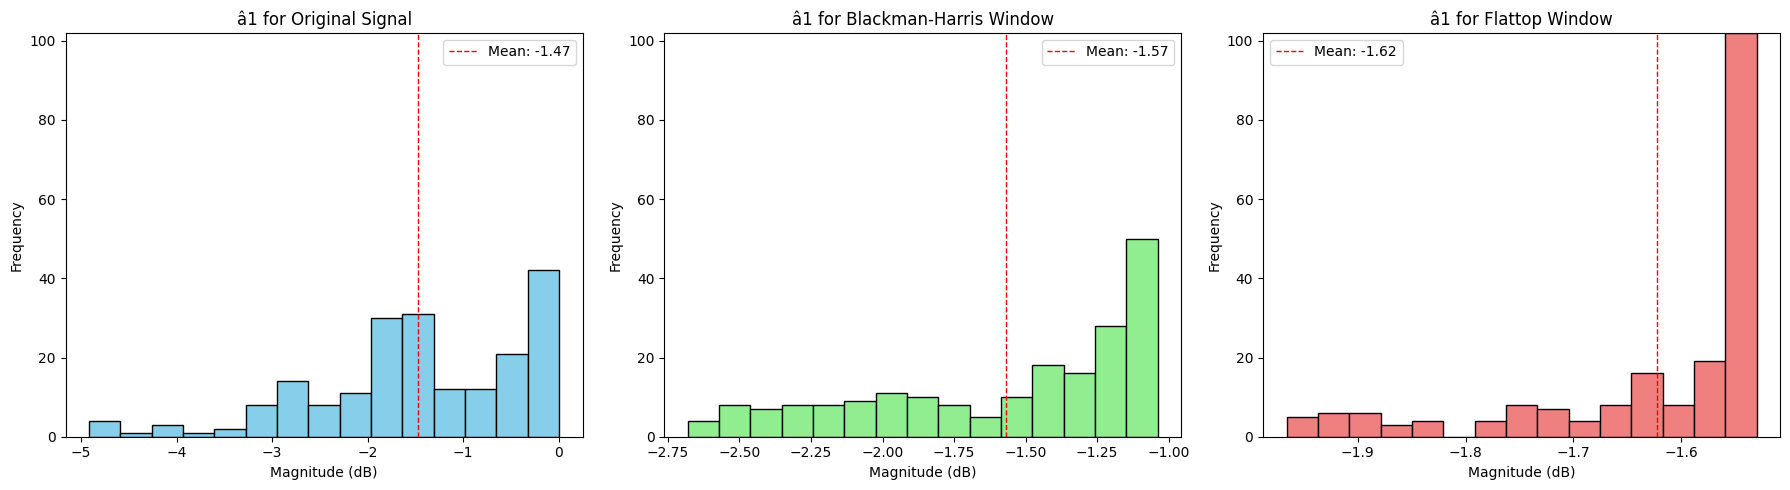

In [13]:

# Magnitudes for original, Blackman-Harris, and Flattop signals
magnitude_original = np.log(np.abs(a10_hat))
magnitude_bh = np.log(np.abs(a10_hat_bh))
magnitude_ft = np.log(np.abs(a10_hat_ft))

# Calculate statistics for all
mean_original = np.mean(magnitude_original)
mean_bh = np.mean(magnitude_bh)
mean_ft = np.mean(magnitude_ft)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for original signal (No Window)
n_original, bins_original, patches_original = axs[0].hist(magnitude_original, bins=15, color='skyblue', edgecolor='black')
axs[0].axvline(mean_original, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_original:.2f}')
axs[0].set_title('â1 for Original Signal')
axs[0].set_xlabel('Magnitude (dB)')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Plot for Blackman-Harris windowed signal
n_bh, bins_bh, patches_bh = axs[1].hist(magnitude_bh, bins=15, color='lightgreen', edgecolor='black')
axs[1].axvline(mean_bh, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bh:.2f}')
axs[1].set_title('â1 for Blackman-Harris Window')
axs[1].set_xlabel('Magnitude (dB)')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Plot for Flattop windowed signal
n_ft, bins_ft, patches_ft = axs[2].hist(magnitude_ft, bins=15, color='lightcoral', edgecolor='black')
axs[2].axvline(mean_ft, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_ft:.2f}')
axs[2].set_title('â1 for Flattop Window')
axs[2].set_xlabel('Magnitude (dB)')
axs[2].set_ylabel('Frequency')
axs[2].legend()

# Find the global y-axis limit across all histograms
max_y = max(np.max(n_original), np.max(n_bh), np.max(n_ft))

# Set the same y-limit for all subplots
for ax in axs:
    ax.set_ylim(0, max_y)

plt.tight_layout()
plt.show()


### Estimador Ω̂

$$
\hat{\Omega}_1 = \arg \max_{\Omega} \left\{ |X(\Omega)| \right\}
$$

Con este pretendemos estimar no la potencia sino la frecuencia fundamental de la señal medida.

In [10]:
def omega_hat_estimator(signal, N):
    ft = (1 / N) * np.fft.fft(signal, axis=0)
    digital_band = int(N/2)
    ft = ft[:digital_band, :]
    omega_hat = np.argmax(np.abs(ft), axis=0)
    return omega_hat

In [11]:

omega_hat_original = omega_hat_estimator(s, N)
omega_hat_bh = omega_hat_estimator(s_bh, N)
omega_hat_ft = omega_hat_estimator(s_ft, N)

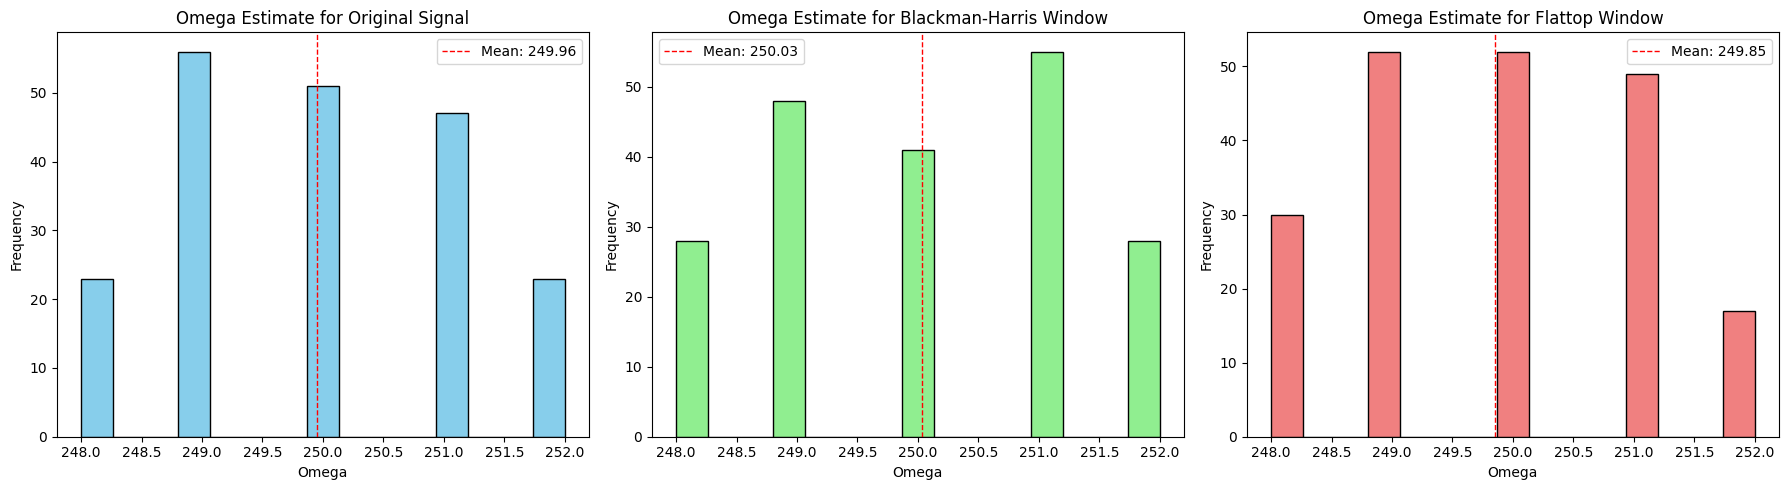

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate omega estimates for each signal
omega_hat_original = omega_hat_estimator(s, N)
omega_hat_bh = omega_hat_estimator(s_bh, N)
omega_hat_ft = omega_hat_estimator(s_ft, N)

# Calculate mean for each set of omega estimates
mean_original = np.mean(omega_hat_original)
mean_bh = np.mean(omega_hat_bh)
mean_ft = np.mean(omega_hat_ft)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for original signal (No Window)
axs[0].hist(omega_hat_original, bins=15, color='skyblue', edgecolor='black')
axs[0].axvline(mean_original, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_original:.2f}')
axs[0].set_title('Omega Estimate for Original Signal')
axs[0].set_xlabel('Omega')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Plot for Blackman-Harris windowed signal
axs[1].hist(omega_hat_bh, bins=15, color='lightgreen', edgecolor='black')
axs[1].axvline(mean_bh, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_bh:.2f}')
axs[1].set_title('Omega Estimate for Blackman-Harris Window')
axs[1].set_xlabel('Omega')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Plot for Flattop windowed signal
axs[2].hist(omega_hat_ft, bins=15, color='lightcoral', edgecolor='black')
axs[2].axvline(mean_ft, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_ft:.2f}')
axs[2].set_title('Omega Estimate for Flattop Window')
axs[2].set_xlabel('Omega')
axs[2].set_ylabel('Frequency')
axs[2].legend()

plt.tight_layout()
plt.show()